In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf, gamma
from matplotlib.colors import LogNorm
import jax
import jax.numpy as jnp

def estimate_forward_KL(X, flow, log_rho_exact):

    # 2. compute log-density under the exact model
    log_ex = log_rho_exact(X)

    # 3. compute log-density under the flow estimate
    log_est = flow.log_prob(X)

    # 4. Monte Carlo KL
    kl_mc = np.mean(log_ex - log_est)
    return kl_mc

In [4]:
class NormalizingFlow:
    """
    An implementation of the non-parametric density estimator using normalizing flows,
    as described in "A family of non-parametric density estimation algorithms"
    by E. G. Tabak and C. V. Turner.

    This implementation uses the method of composing simple, localized
    radial expansion maps. The parameters of each map are found by maximizing a
    local quadratic approximation to the log-likelihood.
    """

    def __init__(self, n_p=50, epsilon=0.5):
        """
        Initializes the density estimator.

        Args:
            n_p (int): The typical number of points each local map should influence.
                       This controls the resolution or "bandwidth" of the estimate.
                       Corresponds to n_p in equation (13) of the paper.
            epsilon (float): The maximum step size for the parameter of each map.
                             This caps the learning rate to ensure stability.
        """
        self.n_p = n_p
        self.epsilon = epsilon
        self.maps = []
        self.preconditioning = {}
        self.kl_history = []

    def _volume_n_ball(self, n):
        """Calculates the volume of an n-dimensional unit ball."""
        return np.pi**(n/2) / gamma(n/2 + 1)

    def _calculate_alpha(self, x0, n, m):
        """
        Calculates the length-scale 'alpha' for a map centered at x0,
        based on equation (13) from the paper. The goal is to have the
        map's influence cover roughly n_p points.

        Args:
            x0 (np.ndarray): The center of the elementary map.
            n (int): The dimensionality of the data space.
            m (int): The total number of data points.

        Returns:
            float: The calculated alpha.
        """
        omega_n = self._volume_n_ball(n)
        # The formula in the paper is derived for a target normal distribution.
        # It adapts the map's radius to be larger in low-density regions.
        term = (omega_n**-1 * self.n_p / m)**(1/n)
        alpha = (2 * np.pi)**0.5 * term * np.exp(np.linalg.norm(x0)**2 / (2*n))
        return alpha

    def _radial_f(self, r, alpha):
        """
        The radial localization function f(r), based on equation (24).
        Handles the r=0 case to avoid division by zero.

        Args:
            r (np.ndarray): Array of radial distances ||x - x0||.
            alpha (float): The length-scale of the map.

        Returns:
            np.ndarray: The value of the localization function.
        """
        # Handle r=0 separately to avoid division by zero.
        # The limit of erf(x)/x as x->0 is 2/sqrt(pi).
        f_vals = np.zeros_like(r)
        nonzero_r = r != 0
        zero_r = ~nonzero_r

        r_scaled = r[nonzero_r] / alpha
        f_vals[nonzero_r] = erf(r_scaled) / r[nonzero_r]
        f_vals[zero_r] = 2.0 / (alpha * np.sqrt(np.pi))
        return f_vals

    def _radial_f_prime(self, r, alpha):
        """
        The derivative of the radial localization function, f'(r).
        Handles the r=0 case, where the derivative is 0.

        Args:
            r (np.ndarray): Array of radial distances ||x - x0||.
            alpha (float): The length-scale of the map.

        Returns:
            np.ndarray: The value of the derivative.
        """
        f_prime_vals = np.zeros_like(r)
        nonzero_r = r != 0

        r_nz = r[nonzero_r]
        r_scaled = r_nz / alpha

        term1 = (2.0 / (alpha * np.sqrt(np.pi))) * np.exp(-r_scaled**2)
        term2 = erf(r_scaled) / r_nz
        f_prime_vals[nonzero_r] = (term1 - term2) / r_nz

        return f_prime_vals

    def calc_beta_threshold(self,x_0,alpha,n):
        A = np.zeros((n,n))
        for p in self.maps:
            if not p['x0'].any():
                break
            r = np.linalg.vector_norm(x_0-p['x0'])
            ctemp = p['beta']*(self._radial_f(np.array([r]),alpha)+r*self._radial_f_prime(np.array([r]),alpha))
            ci = ctemp[0]
            xi = (x_0-p['x0'])/r
            # print(xi,xi[:,np.newaxis]*xi)
            A += ci*(xi[:,np.newaxis]*xi)
        # print(A)
        # return -np.inf
        # print(A)
        eig = np.linalg.eigvals(A)
        if not np.isfinite(eig).any():
            # print("Warning: eigenvalues not finite")
            return -np.inf
        min_eig = np.min(eig)
        r0 = self._radial_f(np.array([0.0]),alpha)
        threshold = - (1 + min_eig)/r0[0]
        # if threshold > 0:
        #     print("min eig:", min_eig)
        return threshold


    def fit(self, x, log_rho_exact=None, n_steps=1000):
        """
        Fits the density model to the data by building a sequence of maps.
        """
        m, n = x.shape
        tol = 1e-9 # Tolerance for Hessian

        # Starting map
        mean = np.mean(x, axis=0)
        z0 = x - mean
        std = np.sqrt(np.mean(np.sum(z0**2, axis=1)) / n)
        z0 /= std

        z = z0

        self.preconditioning = {'mean': mean, 'std': std}
        self.maps = []


        J = np.tile(np.eye(n)[np.newaxis, ...], (m, 1, 1))
        # Iterative map building
        for i in range(n_steps):
            # 1. Select a center x0
            if np.random.rand() > 0.5:
                # Pick from the actual observations at their current normalized state
                idx = np.random.randint(m)
                x0 = z[idx]
            else:
                # Sample the target normal distribution to keep x0 from becoming too large
                x0 = np.random.randn(n)

            # 2. Calculate length-scale alpha
            alpha = self._calculate_alpha(x0, n, m)

            # 3. Calculate Gradient (G) and Hessian (H) of log-likelihood
            r = np.linalg.norm(z0 - x0, axis=1)
            f = self._radial_f(r, alpha)
            f_prime = self._radial_f_prime(r, alpha)

            term_1 = np.sum(f*np.sum(z*(z0-x0),axis = 1),axis=0)
            J_inverse = np.linalg.inv(J)
            trace_term_1 = np.sum(f*np.linalg.trace(J_inverse))

            diff = z0-x0
            outer_product = diff[:, :, np.newaxis] * diff[:, np.newaxis, :]
            trace_term_2 = np.sum(f_prime*np.linalg.trace(J_inverse @ outer_product)/r)

            G =  trace_term_1 + trace_term_2 - term_1



            # term_G = n + np.dot(z, x0) - np.sum(z**2, axis=1)
            # G = np.sum(term_G * f + r * f_prime)

            # term_H1 = (n + r**2) * f**2
            # term_H2 = 2 * r * f * f_prime
            # term_H3 = (r * f_prime)**2
            # H = -np.sum(term_H1 + term_H2 + term_H3)
            #
            # if np.abs(H) < tol:
            #     continue
            v = self.epsilon/(np.sqrt(self.epsilon**2+G**2))

            beta = v*G

            beta_threshold = self.calc_beta_threshold(x0,alpha,n)

            # if beta_threshold > beta:
            #     print("Beta is below threshold. Beta threshold is:" + str(beta_threshold))

            beta = np.maximum(beta,beta_threshold)







            # kl_before = estimate_forward_KL(x, self, log_rho_exact)

            # 4. Calculate optimal step beta and constrain it
            # beta = -G / H
            # beta = np.clip(beta, -self.epsilon, self.epsilon)

            # 5. Apply the map to transform the data
            z = z + beta * f[:, np.newaxis] * (z0 - x0)

            J = J + beta*f.reshape(-1,1,1)*np.identity(n) + beta*(f_prime/r).reshape(-1,1,1)*outer_product

            # 6. Store the map's parameters
            self.maps.append({'x0': x0, 'alpha': alpha, 'beta': beta})


            # Estimate the KL divergence if the exact log density is provided
            if log_rho_exact is not None:
                kl = estimate_forward_KL(x, self, log_rho_exact)
                self.kl_history.append(kl)

            # if kl_before < kl:
            #     self.maps.pop()
            #     self.kl_history.pop()


            if (i+1) % (n_steps//10) == 0:
                if log_rho_exact is None:
                    print(f"Step {i+1}/{n_steps} completed")
                else:
                    kl = estimate_forward_KL(x, self, log_rho_exact)
                    print(f"Step {i+1}/{n_steps} completed, KL estimate: {kl:.4f}")


    def _transform(self, x_new):
        """Applies the full sequence of learned maps to new data."""
        if x_new.ndim == 1:
            x_new = x_new.reshape(1, -1)
        m, n = x_new.shape

        # Apply preconditioning
        z0 = (x_new - self.preconditioning['mean']) / self.preconditioning['std']

        z = z0

        # Calculate initial log Jacobian from preconditioning
        log_J = np.full(m, -n * np.log(self.preconditioning['std']))

        J = np.tile(np.eye(n)[np.newaxis, ...], (m, 1, 1))

        # Apply sequence of maps
        for p in self.maps:
            x0, alpha, beta = p['x0'], p['alpha'], p['beta']

            r = np.linalg.norm(z0 - x0, axis=1)
            f = self._radial_f(r, alpha)
            f_prime = self._radial_f_prime(r, alpha)

            diff = z0-x0
            outer_product = diff[:, :, np.newaxis] * diff[:, np.newaxis, :]

            J += beta*f.reshape(-1,1,1)*np.identity(n) + beta*(f_prime/r).reshape(-1,1,1)*outer_product


            # # Update log Jacobian determinant
            # term1 = 1 + beta * f
            # term2 = 1 + beta * (f + r * f_prime)
            #
            # valid_map = (term1 > 0) & (term2 > 0)
            #
            # log_J_update = np.zeros(m)
            # if np.any(valid_map):
            #     log_J_update[valid_map] = (n - 1) * np.log(term1[valid_map]) + np.log(term2[valid_map])
            # log_J += log_J_update

            # Apply the map
            z = z + beta * f[:, np.newaxis] * (z0 - x0)


        log_J = log_J + np.log(np.abs(np.linalg.det(J)))

        return z, log_J

    def log_prob(self, x_new):
        """
        Calculates the log probability density log(rho(x)) for new data points.

        Args:
            x_new (np.ndarray): New data points, shape (m, n).

        Returns:
            np.ndarray: The log probability for each point.
        """
        m, n = x_new.shape

        # Transform data to the target distribution space (y) and get log Jacobian
        y, log_J = self._transform(x_new)

        # Calculate log probability in the target Gaussian space
        log_prob_gaussian = -0.5 * np.sum(y**2, axis=1) - 0.5 * n * np.log(2 * np.pi)

        # Final log probability is log(rho(x)) = log(mu(y(x))) + log(J(x))
        return log_prob_gaussian + log_J

    def sample(self, n_samples):
        """
        Generates samples from the learned density model.

        Args:
            n_samples (int): Number of samples to generate.

        Returns:
            np.ndarray: Generated samples, shape (n_samples, n).
        """
        # Sample from the standard normal distribution
        y_samples = np.random.randn(n_samples, len(self.maps[0]['x0']))

        # Apply the inverse of the learned maps to get samples in the original space
        z_samples_0 = y_samples.copy()

        z_samples = z_samples_0.copy()


        for p in reversed(self.maps):
            x0, alpha, beta = p['x0'], p['alpha'], p['beta']
            r = np.linalg.norm(z_samples - x0, axis=1)
            f = self._radial_f(r, alpha)

            # Apply the inverse map
            z_samples = z_samples - beta * f[:, np.newaxis] * (z_samples_0 - x0)

        # Apply preconditioning to get back to original space
        return z_samples * self.preconditioning['std'] + self.preconditioning['mean']


In [5]:
import numpy as np

def sample_exact(n_samples):
    theta = np.random.randn(n_samples)
    r     = 1.0 + 0.1 * np.random.randn(n_samples)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return np.stack([x, y], axis=1)

def log_rho_exact(xy):
    x = xy[:,0]
    y = xy[:,1]
    r     = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)


    log_p_theta = -0.5*theta**2 - 0.5*np.log(2*np.pi)

    log_p_r = (
        -0.5*((r - 1.0)/0.1)**2
        - 0.5*np.log(2*np.pi*0.1**2)
    )

    # log Jacobian term
    log_jac = -np.log(r)

    return log_p_theta + log_p_r + log_jac

In [6]:
x = sample_exact(1000)  # Sample from the true target density
flow = NormalizingFlow(n_p=50, epsilon=0.1)
n_steps = 600  # Number of steps to fit the model
flow.fit(x=x, log_rho_exact=log_rho_exact, n_steps=n_steps)

Step 60/600 completed, KL estimate: 0.6989
Step 120/600 completed, KL estimate: 0.4604
Step 180/600 completed, KL estimate: 0.3847
Step 240/600 completed, KL estimate: 0.3304
Step 300/600 completed, KL estimate: 0.3163
Step 360/600 completed, KL estimate: 0.3362
Step 420/600 completed, KL estimate: 0.3270
Step 480/600 completed, KL estimate: 0.2392
Step 540/600 completed, KL estimate: -0.0000
Step 600/600 completed, KL estimate: 0.0233


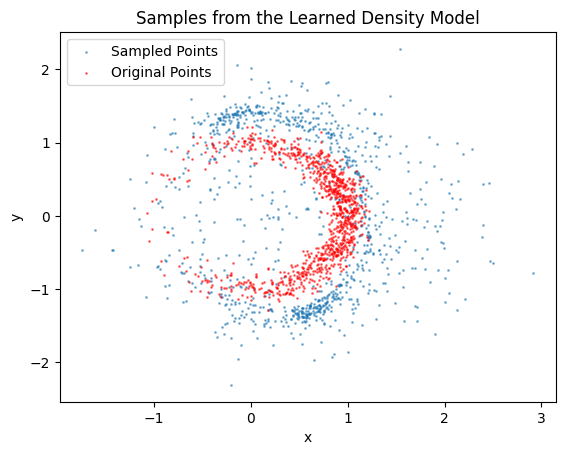

In [8]:
samples = flow.sample(1000)  # Generate samples from the learned density model

plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5, label='Sampled Points')
plt.scatter(x[:, 0], x[:, 1], s=1, alpha=0.5, color='red', label='Original Points')
plt.title('Samples from the Learned Density Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

([<matplotlib.axis.YTick at 0x12a29d790>,
 [Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5')])

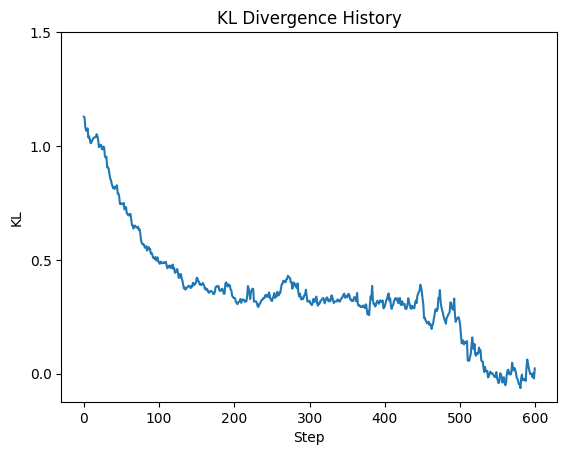

In [11]:
plt.plot(flow.kl_history)
plt.title('KL Divergence History')
plt.xlabel('Step')
plt.ylabel('KL')
plt.yticks([0, 0.5, 1.0, 1.5])

Step 60/600 completed
Step 120/600 completed
Step 180/600 completed
Step 240/600 completed
Step 300/600 completed
Step 360/600 completed
Step 420/600 completed
Step 480/600 completed
Step 540/600 completed
Step 600/600 completed


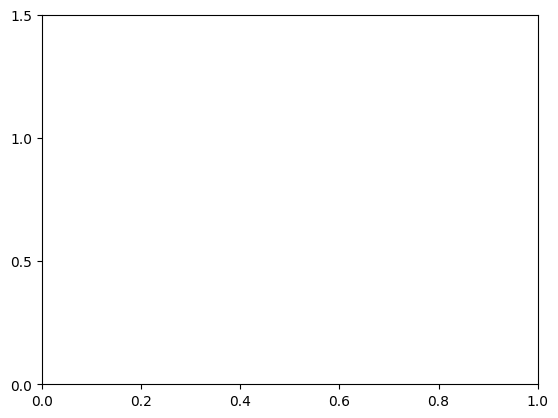

In [12]:
plt.yticks([0, 0.5, 1.0, 1.5])
# Test Case 1
# This creates a crescent-shaped distribution, similar to the paper
m = 1000
angle = np.random.uniform(-np.pi / 2, np.pi / 2, m)
radius = 1.0 + 0.1 * np.random.randn(m)
x = np.zeros((m, 2))
x[:, 0] = radius * np.cos(angle)
x[:, 1] = radius * np.sin(angle)
x += 0.02 * np.random.randn(m, 2)

# Train the model
# Using parameters similar to the paper.
# n_p = 50
# n_steps = 500.
model = NormalizingFlow(n_p=50, epsilon=0.5)
model.fit(x, n_steps=600)

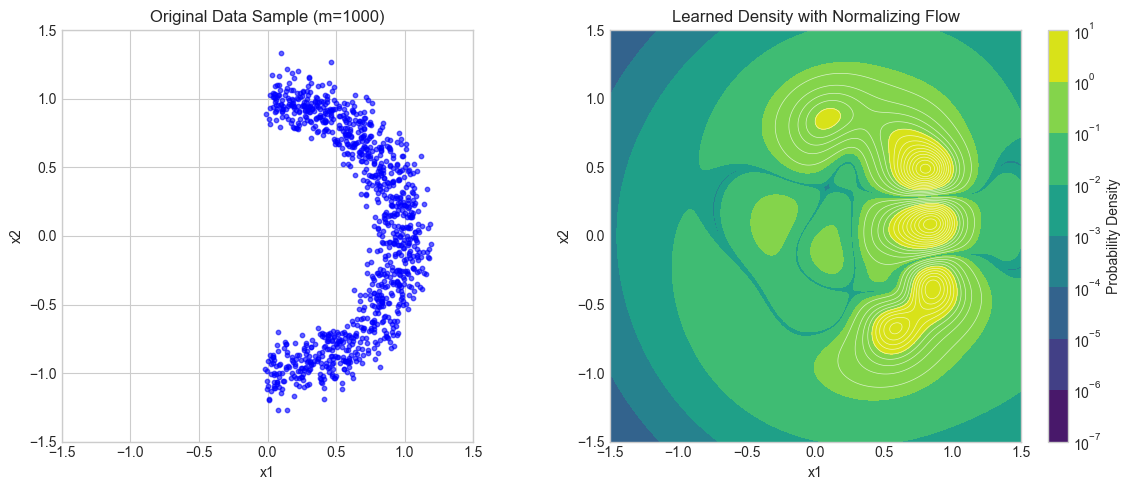

In [13]:
# Results
# Create a grid of points to evaluate the learned density
grid_res = 1000
x_range = np.linspace(-1.5, 1.5, grid_res)
y_range = np.linspace(-1.5, 1.5, grid_res)
xx, yy = np.meshgrid(x_range, y_range)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Calculate the probability on the grid
log_p = flow.log_prob(grid_points)
p = np.exp(log_p).reshape(grid_res, grid_res)

# Plotting
plt.style.use('seaborn-v0_8-whitegrid')
fig = plt.figure(figsize=(12, 5))

# Plot 1: Original Data
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(x[:, 0], x[:, 1], s=10, alpha=0.6, c='blue')
ax1.set_title("Original Data Sample (m=1000)")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")
ax1.set_aspect('equal', adjustable='box')
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)

# Plot 2: Learned Density
ax2 = fig.add_subplot(1, 2, 2)
# Use LogNorm for better visualization of low-density areas
contour = ax2.contourf(xx, yy, p, levels=15, cmap='viridis', norm=LogNorm())
ax2.contour(xx, yy, p, levels=15, colors='white', linewidths=0.5, alpha=0.7)
fig.colorbar(contour, ax=ax2, label="Probability Density")
ax2.set_title("Learned Density with Normalizing Flow")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")
ax2.set_aspect('equal', adjustable='box')
ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()